In [1]:
import pycbc
import bilby
import numpy as np
import matplotlib.pylab as plt
import pycbc.psd
import plotsettings

# Beyond-GR lensing Waveform model

In [2]:
from bilby.gw.source import *


def ModelGenericBeyondGRLensingBBH(
    frequency_array,
    mass_1,
    mass_2,
    luminosity_distance,
    a_1,
    tilt_1,
    phi_12,
    a_2,
    tilt_2,
    phi_jl,
    theta_jn,
    phase,
    t12=0.0,
    lens_angle=0,
    **kwargs
):

    gr_polarizations = lal_binary_black_hole(
        frequency_array,
        mass_1,
        mass_2,
        luminosity_distance,
        a_1,
        tilt_1,
        phi_12,
        a_2,
        tilt_2,
        phi_jl,
        theta_jn,
        phase,
        **kwargs
    )
    Delta = np.exp(1j * frequency_array * 2 * np.pi * t12)
    hp, hc = gr_polarizations["plus"], gr_polarizations["cross"]
    cos_term = np.cos(4 * lens_angle)
    sin_term = np.sin(4 * lens_angle)

    waveform_polarizations = dict()

    waveform_polarizations["plus"] = (
        1 / 2.0 * ((Delta - 1.0) * cos_term + Delta + 1) * hp
        + 1 / 2.0 * (Delta - 1.0) * sin_term * hc
    )
    waveform_polarizations["cross"] = (
        1 / 2.0 * (-(Delta - 1.0) * cos_term + Delta + 1) * hc
        + 1 / 2.0 * (Delta - 1.0) * sin_term * hp
    )

    return waveform_polarizations

In [3]:
import logging
logger = bilby.core.utils.logger
logger.disabled = True

In [21]:
waveform_arguments = dict(waveform_approximant='IMRPhenomXHM',
                          reference_frequency=20., minimum_frequency=20.)
sampling_frequency=2048
duration=12
waveform_generator = bilby.gw.WaveformGenerator(
    duration=duration, sampling_frequency=sampling_frequency,
    frequency_domain_source_model=ModelGenericBeyondGRLensingBBH,parameter_conversion = bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters,waveform_arguments=waveform_arguments)
#asd_file_HL='/home/srashti.goyal/.conda/envs/igwn-py37-hanabi/lib/python3.7/site-packages/bilby/gw/detector/noise_curves/aLIGO_O4_high_asd.txt'
asd_file_HL='/home1/srashti.goyal/anaconda3/envs/bilby_env/lib/python3.7/site-packages/bilby/gw/detector/noise_curves/aLIGO_ZERO_DET_high_P_asd.txt'

delta_f = 1/duration
fhigh = 1024
flen = int(fhigh/delta_f) +1
flow = 20

psd_HL = pycbc.psd.from_txt(asd_file_HL, flen, delta_f,flow, is_asd_file=True)
#psd_file_V='/home/srashti.goyal/.conda/envs/igwn-py37-hanabi/lib/python3.7/site-packages/bilby/gw/detector/noise_curves/AdV_psd.txt'
psd_file_V='/home1/srashti.goyal/anaconda3/envs/bilby_env/lib/python3.7/site-packages/bilby/gw/detector/noise_curves/AdV_psd.txt'

psd_V = pycbc.psd.from_txt(psd_file_V, flen, delta_f,flow, is_asd_file=False)

gauss_noise_injection = False



# compare the GR and nonGRlensing polarisations

In [5]:
GW150914_injection_parameters=dict(mass_1 = 38.3, mass_2 = 33.19, luminosity_distance = 2*558.553,dec = -1.223, ra = 2.269, theta_jn = 2.921, chi_1 = 0.3, chi_2 = 0.27, psi = 1.575, phase = 1.893,geocent_time = 1126259462.414,t12= 0,lens_angle= 0)
gr_pols = waveform_generator.time_domain_strain(parameters=GW150914_injection_parameters)

In [6]:
ngr_pars= GW150914_injection_parameters.copy()
ngr_pars['t12'] = 0.03
ngr_pars['lens_angle'] = 1.09#1.08994031
ngr_pols = waveform_generator.time_domain_strain(parameters=ngr_pars)

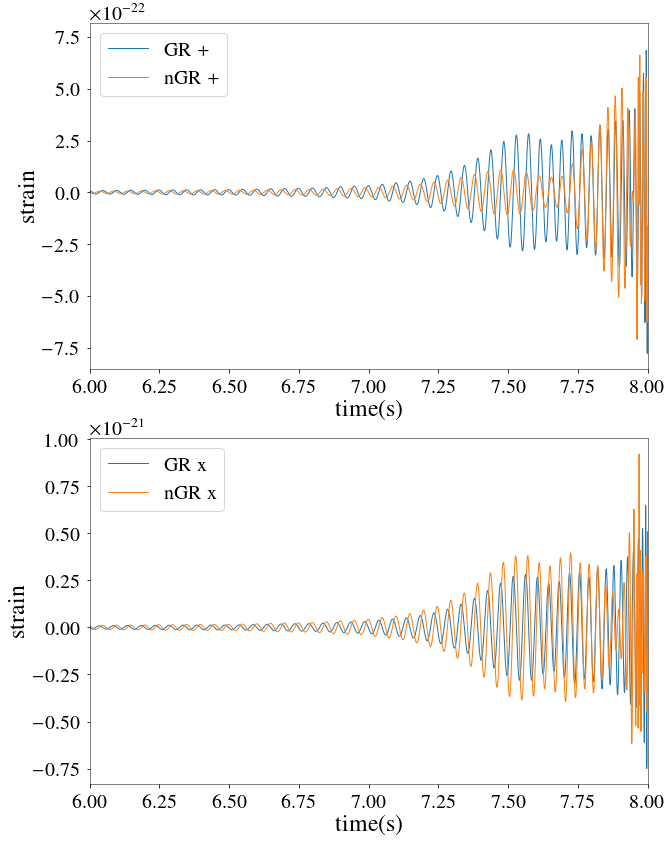

In [7]:
plt.figure(figsize=(10,14))
plt.subplot(211)
plt.plot(waveform_generator.time_array, gr_pols['plus'],label='GR +')
plt.plot(waveform_generator.time_array, ngr_pols['plus'], label = 'nGR +')
plt.xlabel('time(s)')
plt.ylabel('strain')
plt.xlim(6,8)
plt.legend()
plt.subplot(212)
plt.plot(waveform_generator.time_array, gr_pols['cross'],label='GR x')
plt.plot(waveform_generator.time_array, ngr_pols['cross'], label = 'nGR x')
plt.xlabel('time(s)')
plt.ylabel('strain')
plt.xlim(6,8)
plt.legend()
plt.show()

# compare the GR and nonGRlensing strain at each detector

In [8]:
t12_arr = [0.0,0.01,0.01]
lens_angle_arr = [0,np.pi/5,1.09]#[np.pi/4,np.pi/4,np.pi/4]#[1.09,1.09,1.09]
injection_parameters=GW150914_injection_parameters.copy()
ifos1 = bilby.gw.detector.InterferometerList(['H1', 'L1','V1'])
ifos2 = bilby.gw.detector.InterferometerList(['H1', 'L1','V1'])
ifos3 = bilby.gw.detector.InterferometerList(['H1', 'L1','V1'])

#set_strain_data_from_zero_noise
#set_strain_data_from_power_spectral_densities
ifos1.set_strain_data_from_zero_noise(sampling_frequency=sampling_frequency, duration=duration,
   start_time=injection_parameters['geocent_time'] - 6)
ifos2.set_strain_data_from_zero_noise(sampling_frequency=sampling_frequency, duration=duration,
   start_time=injection_parameters['geocent_time'] - 6)
ifos3.set_strain_data_from_zero_noise(sampling_frequency=sampling_frequency, duration=duration,
   start_time=injection_parameters['geocent_time'] - 6)

injection_parameters['t12']=t12_arr[0]
injection_parameters['lens_angle'] = lens_angle_arr[0]
injection_1 = ifos1.inject_signal(waveform_generator=waveform_generator,parameters=injection_parameters)
injection_parameters['t12']=t12_arr[1]
injection_parameters['lens_angle'] = lens_angle_arr[1]
injection_2 = ifos2.inject_signal(waveform_generator=waveform_generator,parameters=injection_parameters)
injection_parameters['t12']=t12_arr[2]
injection_parameters['lens_angle'] = lens_angle_arr[2]
injection_3 = ifos3.inject_signal(waveform_generator=waveform_generator,parameters=injection_parameters)

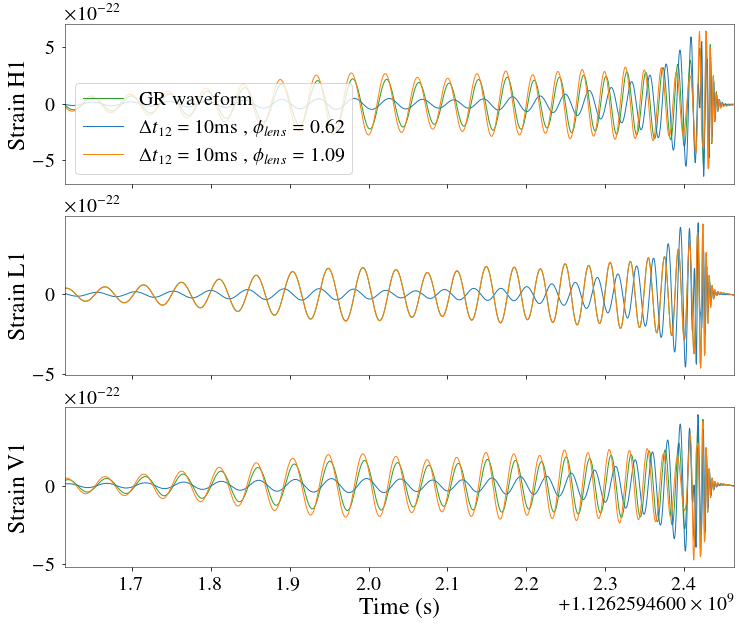

In [9]:
fig, ax = plt.subplots(3,1, figsize=(12,10),sharex=True)


for i in [0,1,2]:

    det = ifos1[i]

    ax[i].plot(det.strain_data.time_array,
              det.strain_data.time_domain_strain, color='C2',
              label= ' GR waveform ')#$\Delta t_{12}$ =  '+ str(t12_arr[0])+ ', $\phi_{lens}$ = '+ str(lens_angle_arr[0])[:4])
   
    det = ifos2[i]

    #ax.set_xtick


    ax[i].plot(det.strain_data.time_array,
              det.strain_data.time_domain_strain,color='C0',
              label= ' $\Delta t_{12}$ =  '+ str(int(t12_arr[1]*1000))+ 'ms , $\phi_{lens}$ = '+ str(lens_angle_arr[1])[:4])

   
    det = ifos3[i]

    ax[i].plot(det.strain_data.time_array,
              det.strain_data.time_domain_strain,color='C1',
              label= ' $\Delta t_{12}$ =  '+ str(int(t12_arr[2]*1000))+ 'ms , $\phi_{lens}$ = '+ str(lens_angle_arr[2])[:4])

    gps_time= injection_parameters['geocent_time']

    ax[i].set_xlim(gps_time - 0.8, gps_time + 0.05)
    ax[i].set_ylabel("Strain " + str(det.name) )



ax[2].set_xlabel("Time (s)")
ax[0].legend(loc='lower left')
plt.savefig('mismatch_plots/GW150914-like-waveform.pdf')    

plt.show()



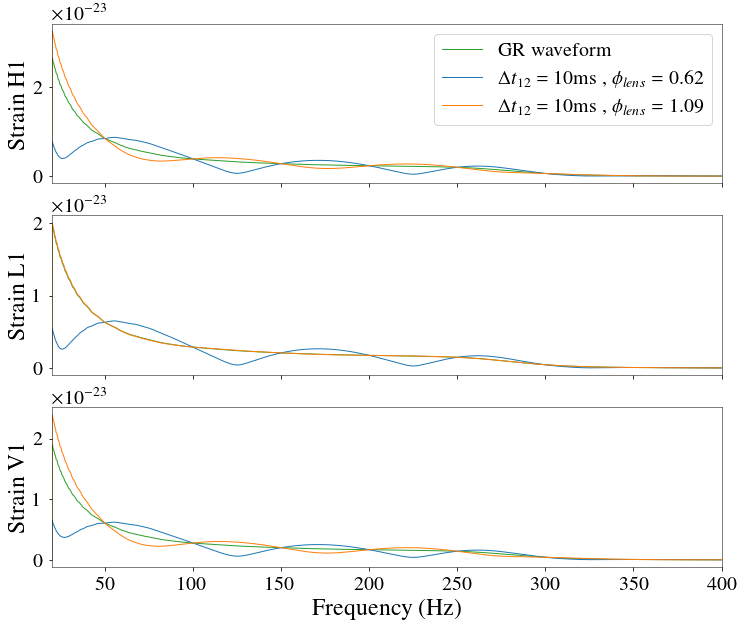

In [10]:
fig, ax = plt.subplots(3,1, figsize=(12,10),sharex=True)


for i in [0,1,2]:

    det = ifos1[i]

    ax[i].plot(det.strain_data.frequency_array,
              np.abs(det.strain_data.frequency_domain_strain), color='C2',
              label= ' GR waveform ')#$\Delta t_{12}$ =  '+ str(t12_arr[0])+ ', $\phi_{lens}$ = '+ str(lens_angle_arr[0])[:4])
   
    det = ifos2[i]

    #ax.set_xtick


    ax[i].plot(det.strain_data.frequency_array,
              np.abs(det.strain_data.frequency_domain_strain),color='C0',
              label= ' $\Delta t_{12}$ =  '+ str(int(t12_arr[1]*1000))+ 'ms , $\phi_{lens}$ = '+ str(lens_angle_arr[1])[:4])

   
    det = ifos3[i]

    ax[i].plot(det.strain_data.frequency_array,
              np.abs(det.strain_data.frequency_domain_strain),color='C1',
              label= ' $\Delta t_{12}$ =  '+ str(int(t12_arr[2]*1000))+ 'ms , $\phi_{lens}$ = '+ str(lens_angle_arr[2])[:4])

    gps_time= injection_parameters['geocent_time']

    ax[i].set_xlim(20, 400)
    ax[i].set_ylabel("Strain " + str(det.name) )



ax[2].set_xlabel("Frequency (Hz)")
ax[0].legend(loc='upper right')
plt.savefig('mismatch_plots/GW150914-like-waveform-fdomain.pdf')    

plt.show()




# mismatch calculations

In [11]:
def calc_mismatch_injections(inj_pars1,inj_pars2, waveform_generator,psd_H,psd_L,psd_V,gauss_noise_injection=True,sampling_frequency=2048,duration=8,flow=20,fhigh=1024):
    """Calculate mismatch between the strains two sets of injection parameters, waveform generator and PSDs."""
    
    ifos1 = bilby.gw.detector.InterferometerList(['H1', 'L1','V1'])
    ifos2 = bilby.gw.detector.InterferometerList(['H1', 'L1','V1'])
    
    if gauss_noise_injection == True :
        ifos1.set_strain_data_from_power_spectral_densities(sampling_frequency=sampling_frequency, duration=duration,
           start_time=inj_pars1['geocent_time'] - 6)
        
    else:

        ifos1.set_strain_data_from_zero_noise(sampling_frequency=sampling_frequency, duration=duration,
           start_time=inj_pars1['geocent_time'] - 6)
    ifos2.set_strain_data_from_zero_noise(sampling_frequency=sampling_frequency, duration=duration,\
                                          start_time=inj_pars2['geocent_time'] - 6)

    inj1 = ifos1.inject_signal(waveform_generator=waveform_generator,parameters=inj_pars1)
    inj2 = ifos2.inject_signal(waveform_generator=waveform_generator,parameters=inj_pars2)
    ts_1_H1 = ifos1[0].strain_data.to_pycbc_timeseries()
    ts_1_L1 = ifos1[1].strain_data.to_pycbc_timeseries()
    ts_1_V1 = ifos1[2].strain_data.to_pycbc_timeseries()

    ts_2_H1 = ifos2[0].strain_data.to_pycbc_timeseries()
    ts_2_L1 = ifos2[1].strain_data.to_pycbc_timeseries()
    ts_2_V1 = ifos2[2].strain_data.to_pycbc_timeseries()
    
    match_H1, shift_H1 = ts_1_H1.match(ts_2_H1,psd=psd_H,low_frequency_cutoff=flow,high_frequency_cutoff=fhigh)
    match_L1, shift_L1 = ts_1_L1.match(ts_2_L1,psd=psd_L,low_frequency_cutoff=flow,high_frequency_cutoff=fhigh)
    match_V1, shift_V1 = ts_1_V1.match(ts_2_V1,psd=psd_V,low_frequency_cutoff=flow,high_frequency_cutoff=fhigh)
    return np.array([1-match_H1,1-match_L1,1-match_V1]), np.array([shift_H1,shift_L1,shift_V1]),np.array([ifos1,ifos2])

In [12]:
def plot_mismatch_t12_phi_grid(t12_grid,phi_grid,mismatchs_arr,save=None):
    plt.figure(figsize=(6,5))
    plt.scatter(t12_grid.flatten(),phi_grid.flatten(),c=np.log(np.sqrt(mismatchs_arr**2).sum(axis=2).flatten()))
    plt.xlabel('$\Delta t_{12}(s)$')
    plt.ylabel('$\phi_{lens}(rad)$')
   # plt.colorbar().set_label('$\log \mathcal{M} $')
    plt.clim(-6,0)
    plt.grid()
    plt.xlim(-0.1,0.1)
    plt.ylim(0,np.pi/2)
    ax=plt.gca()
    ax.set_yticks(np.arange(0, np.pi/2+0.01, np.pi/8))
    labels = ['$0$', r'$\pi/8$', r'$\pi/4$', r'$3\pi/8$', r'$\pi/2$']
    ax.set_yticklabels(labels)
    if save is not None:
        plt.savefig('mismatch_plots/'+save +'.pdf')
   # plt.title('Match nonGR lensed waveform and GR waveform')
    plt.show()

In [13]:
def mismatch_t12_phi_grid(inj_pars_gr,t12_grid,phi_grid, plot=False,save=None,duration=8):
    """ Returns mismatch and shifts 3D arrays nt12 x nphi x ndets"""
    mismatchs_arr = np.zeros([t12_grid.shape[0],t12_grid.shape[1],3])
    shifts_arr = np.zeros([t12_grid.shape[0],t12_grid.shape[1],3])
    for i in range(t12_grid.shape[0]):
        for j in range(t12_grid.shape[1]):
            inj_pars2 = inj_pars_gr.copy()
            inj_pars2['t12'] = t12_grid[i,j]
            inj_pars2['lens_angle']=phi_grid[i,j]
            mismatchs,shifts,ifos =calc_mismatch_injections(inj_pars_gr,inj_pars2, waveform_generator,psd_HL,psd_HL,psd_V,gauss_noise_injection=False,duration=duration)
            mismatchs_arr[i,j,:],shifts_arr[i,j,:] =  mismatchs,shifts
    if save is not None:
         np.savez('mismatch_plots/'+save+'.npz', t12_grid=t12_grid,phi_grid=phi_grid,mismatchs_arr=mismatchs_arr,shifts_arr=shifts_arr)
            
    if plot == True:
        plot_mismatch_t12_phi_grid(t12_grid,phi_grid,mismatchs_arr,save=save)
    return mismatchs_arr,shifts_arr

In [14]:
t12_arr = np.linspace(-0.1,0.1,101)
phi_arr = np.linspace(0,np.pi/2,101)
t12_grid,phi_grid=np.meshgrid(t12_arr,phi_arr)

### BBH like system: GW150914

In [15]:
GW150914_injection_parameters=dict(mass_1 = 38.3, mass_2 = 33.19, luminosity_distance = 2*558.553,dec = -1.223, ra = 2.269, theta_jn = 2.921, chi_1 = 0.3, chi_2 = 0.27, psi = 1.575, phase = 1.893,geocent_time = 1126259462.414,t12= 0,lens_angle= 0)

/home1/srashti.goyal/anaconda3/envs/bilby_env/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until


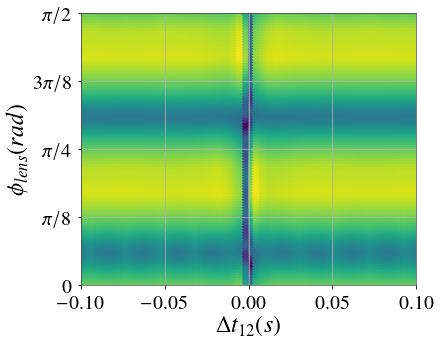

In [16]:
mismatchs_arr,shifts_arr=mismatch_t12_phi_grid(GW150914_injection_parameters,t12_grid,phi_grid,plot=True,save='re-GW150914-like-gr')

/home1/srashti.goyal/anaconda3/envs/bilby_env/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until


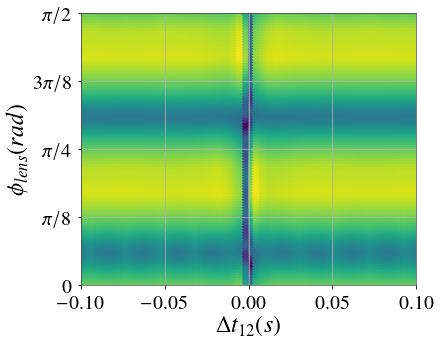

In [17]:
plot_mismatch_t12_phi_grid(t12_grid,phi_grid,mismatchs_arr,save='re-GW150914-like-gr')

In [18]:
t12_grid.shape

(101, 101)

In [19]:
ids=np.where(mismatchs_arr.sum(axis=2)<np.exp(-5))

In [20]:
np.set_printoptions(precision=4)


In [21]:
print('Maximum match at: \n t12(s) \t lens_angle/pi \t shift H1 \t shift L1 \t shift V1 \n',np.vstack([t12_grid[ids],phi_grid[ids]/np.pi,shifts_arr[:,:,0][ids],shifts_arr[:,:,1][ids],shifts_arr[:,:,2][ids]]).T)

Maximum match at: 
 t12(s) 	 lens_angle/pi 	 shift H1 	 shift L1 	 shift V1 
 [[ 0.0000e+00  0.0000e+00  0.0000e+00  0.0000e+00  0.0000e+00]
 [ 0.0000e+00  5.0000e-03  0.0000e+00  0.0000e+00  0.0000e+00]
 [ 0.0000e+00  1.0000e-02  0.0000e+00  0.0000e+00  0.0000e+00]
 [ 0.0000e+00  1.5000e-02  0.0000e+00  0.0000e+00  0.0000e+00]
 [ 0.0000e+00  2.0000e-02  0.0000e+00  0.0000e+00  0.0000e+00]
 [ 0.0000e+00  2.5000e-02  0.0000e+00  0.0000e+00  0.0000e+00]
 [ 0.0000e+00  3.0000e-02  0.0000e+00  0.0000e+00  0.0000e+00]
 [ 2.0000e-03  3.0000e-02  1.6380e+04  1.6381e+04  1.6380e+04]
 [ 0.0000e+00  3.5000e-02  0.0000e+00  0.0000e+00  0.0000e+00]
 [ 2.0000e-03  3.5000e-02  1.6380e+04  1.6381e+04  1.6380e+04]
 [ 0.0000e+00  4.0000e-02  0.0000e+00  0.0000e+00  0.0000e+00]
 [ 2.0000e-03  4.0000e-02  1.6380e+04  1.6381e+04  1.6380e+04]
 [ 0.0000e+00  4.5000e-02  0.0000e+00  0.0000e+00  0.0000e+00]
 [ 2.0000e-03  4.5000e-02  1.6380e+04  1.6381e+04  1.6380e+04]
 [ 0.0000e+00  5.0000e-02  0.0000e+00  0

*Note*: # of shifts mean no. of indexes of the time array to shift for maximum match 

### NSBH-like system: GW190814

https://ldas-jobs.ligo.caltech.edu/~charlie.hoy/PE/O3/S190814bv/C01/PhenomPv2/git_repo/html/Prod1_Prod1.html

In [27]:
GW190814_injection_parameters= dict(mass_1 = 24.45, mass_2 = 2.71, luminosity_distance = 295.18,dec = -0.436, ra = 0.217, theta_jn = 0.51, chi_1 = 0.06, chi_2 = 0.46, psi = 1.575, phase = 4.421,geocent_time = 1249852256.99,t12= 0,lens_angle= 0)


In [ ]:
mismatchs_arr_nsbh,shifts_arr_nsbh=mismatch_t12_phi_grid(GW190814_injection_parameters,t12_grid,phi_grid,plot=True,save='re-GW190814-like-gr',duration=duration)


In [ ]:
ids=np.where(mismatchs_arr_nsbh.sum(axis=2)<np.exp(-4))

In [ ]:
#print('Maximum match at: \n t12(s) \t lens_angle/pi \t shift H1 \t shift L1 \t shift V1 \n',np.vstack([t12_grid[ids],phi_grid[ids]/np.pi,shifts_arr_nsbh[:,:,0][ids],shifts_arr_nsbh[:,:,1][ids],shifts_arr_nsbh[:,:,2][ids]]).T)

#### increasing HM content in GW190814 like event by changing inclination angle

In [ ]:
GW190814_injection_parameters_inclined_5piby12 =GW190814_injection_parameters.copy()
GW190814_injection_parameters_inclined_5piby12['theta_jn'] = 5*np.pi/12

In [ ]:
mismatchs_arr_nsbh1,shifts_arr_nsbh1=mismatch_t12_phi_grid(GW190814_injection_parameters_inclined_5piby12,t12_grid,phi_grid,plot=True,save='re-GW190814-like-gr-hom',duration=duration)

In [ ]:
ids=np.where(mismatchs_arr_nsbh1.sum(axis=2)<np.exp(-4))

In [ ]:
print('Maximum match at: \n t12(s) \t lens_angle/pi \t shift H1 \t shift L1 \t shift V1 \n',np.vstack([t12_grid[ids],phi_grid[ids]/np.pi,shifts_arr_nsbh1[:,:,0][ids],shifts_arr_nsbh1[:,:,1][ids],shifts_arr_nsbh1[:,:,2][ids]]).T)

### making nonGR injection and nonGR recovery

at t12 = 0.01 sec

and lens_angle =  pi/5

In [ ]:
GW190814_injection_parameters_ngr= GW190814_injection_parameters.copy()
GW190814_injection_parameters_ngr['t12'] =0.01
GW190814_injection_parameters_ngr['lens_angle'] =np.pi/5

mismatchs_arr_nsbh2,shifts_arr_nsbh2=mismatch_t12_phi_grid(GW190814_injection_parameters_ngr,t12_grid,phi_grid,plot=True,save='re-GW190814-like-nongr',duration=duration)

In [ ]:
ids=np.where(mismatchs_arr_nsbh2.sum(axis=2)<np.exp(-4))

In [ ]:
print('Maximum match at: \n t12(s) \t lens_angle/pi \t shift H1 \t shift L1 \t shift V1 \n',np.vstack([t12_grid[ids],phi_grid[ids]/np.pi,shifts_arr_nsbh2[:,:,0][ids],shifts_arr_nsbh2[:,:,1][ids],shifts_arr_nsbh2[:,:,2][ids]]).T)

### BBH like system: GW150914 NGR inj

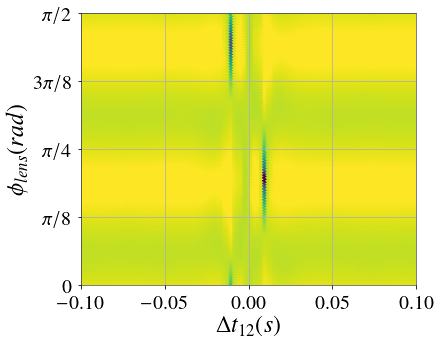

In [24]:
GW150914_injection_parameters_ngr= GW150914_injection_parameters.copy()
GW150914_injection_parameters_ngr['t12'] =0.01
GW150914_injection_parameters_ngr['lens_angle'] =np.pi/5

mismatchs_arr_ngr,shifts_arr_ngr=mismatch_t12_phi_grid(GW150914_injection_parameters_ngr,t12_grid,phi_grid,plot=True,save='re-GW150914-like-nonngr')

In [25]:
ids=np.where(mismatchs_arr_ngr.sum(axis=2)<np.exp(-4))

In [26]:
print('Maximum match at: \n t12(s) \t lens_angle/pi \t shift H1 \t shift L1 \t shift V1 \n',np.vstack([t12_grid[ids],phi_grid[ids]/np.pi,shifts_arr_ngr[:,:,0][ids],shifts_arr_ngr[:,:,1][ids],shifts_arr_ngr[:,:,2][ids]]).T)

Maximum match at: 
 t12(s) 	 lens_angle/pi 	 shift H1 	 shift L1 	 shift V1 
 [[ 1.00e-02  1.85e-01  0.00e+00  0.00e+00  0.00e+00]
 [ 1.00e-02  1.90e-01  0.00e+00  0.00e+00  0.00e+00]
 [ 1.00e-02  1.95e-01  0.00e+00  0.00e+00  0.00e+00]
 [ 1.00e-02  2.00e-01  0.00e+00  0.00e+00  0.00e+00]
 [ 1.00e-02  2.05e-01  0.00e+00  0.00e+00  0.00e+00]
 [ 1.00e-02  2.10e-01  0.00e+00  0.00e+00  0.00e+00]
 [ 1.00e-02  2.15e-01  0.00e+00  0.00e+00  0.00e+00]
 [-1.00e-02  4.40e-01  2.00e+01  2.00e+01  2.00e+01]
 [-1.00e-02  4.45e-01  2.00e+01  2.00e+01  2.00e+01]
 [-1.00e-02  4.50e-01  2.00e+01  2.00e+01  2.00e+01]
 [-1.00e-02  4.55e-01  2.10e+01  2.10e+01  2.10e+01]
 [-1.00e-02  4.60e-01  2.10e+01  2.10e+01  2.10e+01]]


In [ ]:
#ids

# Plot again the saved mismatch calculations

In [33]:
def plot_mismatch_t12_phi_grid(t12_grid,phi_grid,mismatchs_arr,save=None):
    plt.figure(figsize=(8,6))
    plt.scatter(t12_grid.flatten()*1000,phi_grid.flatten(),c=np.log(mismatchs_arr[:,:,0]))#np.log(np.sqrt((mismatchs_arr**2).sum(axis=2)).flatten()))
    #plt.scatter(t12_grid.flatten()*1000,phi_grid.flatten(),c=np.log(np.sqrt((mismatchs_arr**2).sum(axis=2)).flatten()))

    plt.xlabel('$\Delta t_{12}(ms)$')
    plt.ylabel('$\phi_{lens}(rad)$')
   # plt.colorbar().set_label('$\log \mathcal{M} $')
    plt.clim(-6,0)
    #plt.grid()
    plt.xlim(-100,100)
    plt.ylim(0,np.pi/2)
    ax=plt.gca()
    ax.set_yticks(np.arange(0, np.pi/2+0.01, np.pi/8))
    labels = ['$0$', r'$\pi/8$', r'$\pi/4$', r'$3\pi/8$', r'$\pi/2$']
    ax.set_yticklabels(labels)
    if save is not None:
        plt.savefig('mismatch_plots/'+save +'.pdf')
   # plt.title('Match nonGR lensed waveform and GR waveform')
    plt.show()

## Mismatch

$1-\frac{ \Sigma \rho_i^2 Match_i}{\Sigma \rho_i^2 }$

$\rho_i$ of the injection at Ith detector.


In [ ]:
fname='re-GW150914-like-nongr'
data=np.load('mismatch_plots/'+fname+'.npz')

In [ ]:
t12_grid = data['t12_grid']
phi_grid = data['phi_grid']
mismatchs_arr=data['mismatchs_arr']
plot_mismatch_t12_phi_grid(t12_grid,phi_grid,mismatchs_arr,save=None)#fname)

In [ ]:
mismatchs_arr.shape

In [ ]:
(mismatchs_arr).max()

In [ ]:
import matplotlib.pyplot as plt
import matplotlib as mpl

fig = plt.figure()
ax = fig.add_axes([0.05, 0.80, 0.9, 0.1])

cb = mpl.colorbar.ColorbarBase(ax, orientation='horizontal',label='log $\mathcal{M}$',
                               norm=mpl.colors.Normalize(-6, 0))

plt.savefig('mismatch_plots/just_colorbar.pdf', bbox_inches='tight')